L'objectif de ce projet est d'observer s'il existe des "déserts sportifs", 
lieux en France où les infrastrcutures sportives manquent. 
La question sera alors d'essayer d'expliquer ces déserts sportifs, que ce soit par des raisons économiques ou politiques. 
Enfin, il s'agira de comparer la carte des déserts sportifs avec d'autres cartes connues, à l'instar des déserts médicaux.

I/ Importation des modules

In [66]:
#Installation des modules
!pip install py7zr geopandas openpyxl tqdm s3fs --quiet
!pip install PyYAML xlrd --quiet
!pip install cartiflette --quiet
!pip install contextily --quiet
!pip install folium --quiet
!pip install nb-clean --quiet
!pip install statsmodels --quiet

In [67]:
#Importation des modules
import numpy as np
import numpy.linalg as al
import matplotlib.pyplot as plt 
import pandas as pd
import geopandas as gpd
from cartiflette import carti_download
import requests
import io
import zipfile
import folium
from folium.plugins import HeatMap
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV


II/ Création de la base de données

Importons les trois jeux de données qui nous intéressent.

In [68]:
%run src/import.py

In [69]:
#Visualisation de la base de données principale
equipement.head(3)

equip_numero inst_numero inst_enqu_date  \
0  E001I774200003  I774200003     2025-03-31   
1  E004I784230006  I784230006     2025-03-31   
2  E001I774250001  I774250001     2025-03-31   

                              inst_nom  inst_siret  \
0  COMPLEXE LA FONTAINE DES TOURNELLES         NaN   
1              CENTRE AQUATIQUE DU LAC         NaN   
2                     COURTS DE TENNIS         NaN   

                   inst_adresse  inst_cp                new_name new_code  \
0  7 BOULEVARD DE LA REPUBLIQUE    77230              Saint-Mard    77420   
1         4 boulevard descartes    78180  Montigny-le-Bretonneux    78423   
2      PARKING DE LA COCHENILLE    77630   Saint-Martin-en-Bière    77425   

  inst_part_type_filter  ... equip_pshs_trib equip_pshs_vest  equip_x  \
0                   NaN  ...           False           False  2.69133   
1               Piscine  ...           False           False  2.03949   
2                   NaN  ...           False           False  2.56801   

    equip_y inst_part_type                               aps_name equip_qpv  \
0  49.03810            NaN  Football / Football en salle (Futsal)       NaN   
1  48.76428    ["Piscine"]         Activités de forme et de santé       NaN   
2  48.43550            NaN                                 Tennis       NaN   

   equip_qpv_200m    categorie gen_2024fin_labellisation  
0             NaN  structurant                       NaN  
1             NaN          NaN                       NaN  
2             NaN          NaN                       NaN  

[3 rows x 113 columns]

In [70]:
#Visualisation de la base de données sur les informations économiques et démographiques
df_communes.head(3)

CODGEO  P22_POP  P16_POP  SUPERF  NAIS1621  DECE1621      P22_MEN  NAISD24  \
0  01001    859.0    767.0   15.95      51.0      33.0   354.000000      8.0   
1  01002    273.0    243.0    9.15      14.0      11.0   121.000000      1.0   
2  01004  15554.0  14081.0   24.60    1325.0     808.0  7107.012476    175.0   

   DECESD24      P22_LOG  ...  P22_CHOM1564  P22_ACT1564  ETTOT23  ETAZ23  \
0       4.0   379.000000  ...     28.000000   431.000000     16.0     4.0   
1       4.0   175.000000  ...      2.000000   133.000000      4.0     1.0   
2     118.0  7973.370708  ...   1005.744641  7479.600207    599.0     1.0   

  ETBE23 ETFZ23 ETGU23 ETOQ23  ETTEF123  ETTEFP1023  
0    0.0    3.0    7.0    2.0      13.0         2.0  
1    0.0    0.0    2.0    1.0       3.0         0.0  
2   31.0   61.0  420.0   86.0     435.0       132.0  

[3 rows x 32 columns]

In [71]:
#Visualisation de la base de données politique
legislatives2.head(3)

Code département Libellé département Code commune          Libellé commune  \
0               01                 Ain        01001  L'Abergement-Clémenciat   
1               01                 Ain        01002    L'Abergement-de-Varey   
2               01                 Ain        01004        Ambérieu-en-Bugey   

   Inscrits  Votants % Votants  Abstentions % Abstentions  Exprimés  ...  \
0       662      494    74,62%          168        25,38%       476  ...   
1       228      187    82,02%           41        17,98%       166  ...   
2      8745     5887    67,32%         2858        32,68%      5348  ...   

  Elu 17 Numéro de panneau 18  Nuance candidat 18 Nom candidat 18  \
0    NaN                  NaN                 NaN             NaN   
1    NaN                  NaN                 NaN             NaN   
2    NaN                  NaN                 NaN             NaN   

  Prénom candidat 18  Sexe candidat 18 Voix 18 % Voix/inscrits 18  \
0                NaN               NaN     NaN                NaN   
1                NaN               NaN     NaN                NaN   
2                NaN               NaN     NaN                NaN   

   % Voix/exprimés 18 Elu 18  
0                 NaN    NaN  
1                 NaN    NaN  
2                 NaN    NaN  

[3 rows x 180 columns]

Sur les plus de 300 colonnes disponibles, on conserve celles qui nous intéressent. 

In [73]:
%run src/lavage.py
from src.lavage import nettoyer_donnees

equipement, df_communes, legislatives2 = nettoyer_donnees(equipement, df_communes, legislatives2)

Nettoyage terminé : colonnes filtrées et variables binaires créées.


In [74]:
#Visualisation nouvelle base de données principale
equipement.head(3)

inst_cp                new_name new_code dep_code  \
0    77230              Saint-Mard    77420       77   
1    78180  Montigny-le-Bretonneux    78423       78   
2    77630   Saint-Martin-en-Bière    77425       77   

                                aps_name                  dens_lib  \
0  Football / Football en salle (Futsal)        Ceintures urbaines   
1         Activités de forme et de santé    Grands centres urbains   
2                                 Tennis  Rural à habitat dispersé   

                       equip_type_name  equip_x   equip_y  
0                  Terrain de football  2.69133  49.03810  
1  Salle de musculation/cardiotraining  2.03949  48.76428  
2                      Court de tennis  2.56801  48.43550

In [75]:
#Visualisation nouvelle base de données sur les informations économiques et démographiques
df_communes.head(3)

CODGEO  P22_POP      P22_MEN  MED21 TP6021  P22_CHOM1564
0  01001    859.0   354.000000  25820      s     28.000000
1  01002    273.0   121.000000  24480      s      2.000000
2  01004  15554.0  7107.012476  21660   17,0   1005.744641

In [76]:
#Visualisation nouvelle base de données politique
legislatives2.head(3)

Code commune          Libellé commune Nuance candidat 1 Nuance candidat 2  \
0        01001  L'Abergement-Clémenciat               ENS                RN   
1        01002    L'Abergement-de-Varey                UG               UXD   
2        01004        Ambérieu-en-Bugey                UG               UXD   

  Nuance candidat 3 Nuance candidat 4  Elu 1  Elu 2  Elu 3  Elu 4  
0               NaN               NaN      0      1      0      0  
1               NaN               NaN      0      1      0      0  
2               NaN               NaN      0      1      0      0

Les noms des colonnes étant des fois compliqués à comprendre, voici des dictionnaires afin de comprendre la signification de chaque colonne. 

In [81]:
%run src/Dictionnaires.py

Dictionaire équipement:


Variable                     Description
0          inst_cp       Code postal de la commune
1         new_name               Nom de la commune
2         new_code        Code INSEE de la commune
3         dep_code             Code du département
4         aps_name                           Sport
5         dens_lib           Densité de la commune
6  equip_type_name  Type d'infrastructure sportive
7          equip_x                       Longitude
8          equip_y                        Latitude


Dictionnaire communes:


Variable                                Description
0        CODGEO                   Code INSEE de la commune
1       P22_POP                         Population en 2022
2       P22_MEN                  Nombre de ménages en 2022
3         MED21           Médiane du niveau de vie en 2021
4        TP6021                   Taux de pauvreté en 2021
5  P22_CHOM1564  Nombre de chômeurs de 15 à 64 ans en 2022


Dictionnaire politique:


Variable  \
0     Code commune   
1  Nuance candidat   
2              Elu   

                                                    Description  
0                                      Code INSEE de la commune  
1                                   Parti politique du candidat  
2  Variable binaire égale à 1 si le candidat a été élu, 0 sinon

In [82]:
#On souhaite créer une variable "Nuance politique du candidat élu" pour notre base de données finale

def get_nuance_elu(row):
    """
    Retourne la nuance du candidat élu pour la commune de la ligne "row"
    """
    if row['Elu 1']:
        return row['Nuance candidat 1']
    elif row['Elu 2']:
        return row['Nuance candidat 2']
    elif row['Elu 3']:
        return row['Nuance candidat 3']
    elif row['Elu 4']:
        return row['Nuance candidat 4']
    else:
        return np.nan

legislatives2['Nuance candidat élu'] = legislatives2.apply(get_nuance_elu, axis=1)

In [83]:
legislatives2.head(3)

Code commune          Libellé commune Nuance candidat 1 Nuance candidat 2  \
0        01001  L'Abergement-Clémenciat               ENS                RN   
1        01002    L'Abergement-de-Varey                UG               UXD   
2        01004        Ambérieu-en-Bugey                UG               UXD   

  Nuance candidat 3 Nuance candidat 4  Elu 1  Elu 2  Elu 3  Elu 4  \
0               NaN               NaN      0      1      0      0   
1               NaN               NaN      0      1      0      0   
2               NaN               NaN      0      1      0      0   

  Nuance candidat élu  
0                  RN  
1                 UXD  
2                 UXD

In [84]:
#On garde seulement la nuance du candidat élu, ce qui nous intéresse ici
cols = ["Code commune", "Nuance candidat élu"]
legislatives2 = legislatives2[cols]
legislatives2.head(3)

Code commune Nuance candidat élu
0        01001                  RN
1        01002                 UXD
2        01004                 UXD

In [85]:
#On réunit tous les jeux de données pour obtenir notre jeu de données final

df_communes = df_communes.rename(columns={"CODGEO": "new_code"})
legislatives2 = legislatives2.rename(columns={"Code commune": "new_code"}) #On renomme les colonnes pour concaténer

df_final = (
    equipement
    .merge(df_communes, on="new_code", how="left")
    .merge(legislatives2, on="new_code", how="left")
)

df_final.head(12)

inst_cp                  new_name new_code dep_code  \
0     77230                Saint-Mard    77420       77   
1     78180    Montigny-le-Bretonneux    78423       78   
2     77630     Saint-Martin-en-Bière    77425       77   
3     78180    Montigny-le-Bretonneux    78423       78   
4     77630     Saint-Martin-en-Bière    77425       77   
5     78130               Les Mureaux    78440       78   
6     77410              Saint-Mesmes    77427       77   
7     78370                   Plaisir    78490       78   
8     77140  Saint-Pierre-lès-Nemours    77431       77   
9     78730               Ponthévrard    78499       78   
10    77140  Saint-Pierre-lès-Nemours    77431       77   
11    77320       Saint-Rémy-la-Vanne    77432       77   

                                                                                                              aps_name  \
0                                                                                Football / Football en salle (Futsal)   
1                                                                                       Activités de forme et de santé   
2                                                                                                               Tennis   
3                                                                                       Activités de forme et de santé   
4                                         Basket-Ball,Volley-ball / Volley-ball de plage (beach-volley) / Green-Volley   
5                           Basket-Ball,Football / Football en salle (Futsal),Handball / Mini hand / Handball de plage   
6                                                                                           Equitation,Saut d'obstacle   
7                           Basket-Ball,Football / Football en salle (Futsal),Handball / Mini hand / Handball de plage   
8                                                                                                     Course sur piste   
9   Basket-Ball,Football / Football en salle (Futsal),Volley-ball / Volley-ball de plage (beach-volley) / Green-Volley   
10                                                                                                            Dressage   
11                                                                                                              Tennis   

                          dens_lib                      equip_type_name  \
0               Ceintures urbaines                  Terrain de football   
1           Grands centres urbains  Salle de musculation/cardiotraining   
2         Rural à habitat dispersé                      Court de tennis   
3           Grands centres urbains            Salle de cours collectifs   
4         Rural à habitat dispersé              Multisports/City-stades   
5   Centres urbains intermédiaires              Multisports/City-stades   
6         Rural à habitat dispersé                               Manège   
7           Grands centres urbains              Multisports/City-stades   
8               Ceintures urbaines                   Stade d’athlétisme   
9                   Petites villes              Multisports/City-stades   
10              Ceintures urbaines                               Manège   
11        Rural à habitat dispersé                      Court de tennis   

     equip_x    equip_y  P22_POP       P22_MEN  MED21 TP6021  P22_CHOM1564  \
0   2.691330  49.038100   3853.0   1437.539509  26890    7,0    193.732241   
1   2.039490  48.764280  32150.0  14566.988700  30360    7,0   1272.399985   
2   2.568010  48.435500    746.0    315.092095  32360      s     32.577365   
3   2.026340  48.766900  32150.0  14566.988700  30360    7,0   1272.399985   
4   2.566436  48.437835    746.0    315.092095  32360      s     32.577365   
5   1.924690  48.985650  34151.0  11576.444583  18240   27,0   2611.363856   
6   2.680349  48.980649    596.0    211.485724  28770      s     18.534032   
7   1.942910  48.818800  31971.0  12692.848504  2

In [91]:
#On supprime des lignes doublons
df_final = df_final.drop_duplicates()

In [92]:
#Maintenant, on va regarder le type des colonnes pour mettre les variables dans le format qui nous arrange

print(df_final.dtypes)

inst_cp                  int64
new_name                object
new_code                object
dep_code                 Int64
aps_name                object
dens_lib                object
equip_type_name         object
equip_x                float64
equip_y                float64
P22_POP                float64
P22_MEN                float64
MED21                    Int64
TP6021                  object
P22_CHOM1564           float64
Nuance candidat élu     object
dtype: object


In [93]:
#On va convertir les Code de départements en entier

#On fait le choix de Remplacer 2A et 2B par 96 et 97
df_final['dep_code'] = df_final['dep_code'].replace({'2A': '96', '2B': '97'})

#On convertit en entier, coerce nous permet de gérer les erreurs en cas de valeur manquante
df_final['dep_code'] = pd.to_numeric(df_final['dep_code'], errors='coerce').astype('Int64')

In [94]:
#Finalement, on ne conserve que les données sur la France métropolitaine, afin de faciliter les 
#représentations graphiques (cartes)

df_final = df_final[1 <= (df_final['dep_code'] <= 97)]

In [95]:
df_final['MED21'] = pd.to_numeric(df_final['MED21'], errors='coerce').astype('Int64')

III/ Représentations graphiques des données

On va maintenant passer à une représentation graphique des données


In [96]:
#On récupère le fond de carte de la france métropolitaine


#Téléchargement de toute la France avec les DROM
gdf = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

#Filtrer pour ne garder que la métropole (exclure les DROM)
departements_drom = ["971", "972", "973", "974", "975", "976"]
gdf = gdf[~gdf['INSEE_DEP'].isin(departements_drom)]

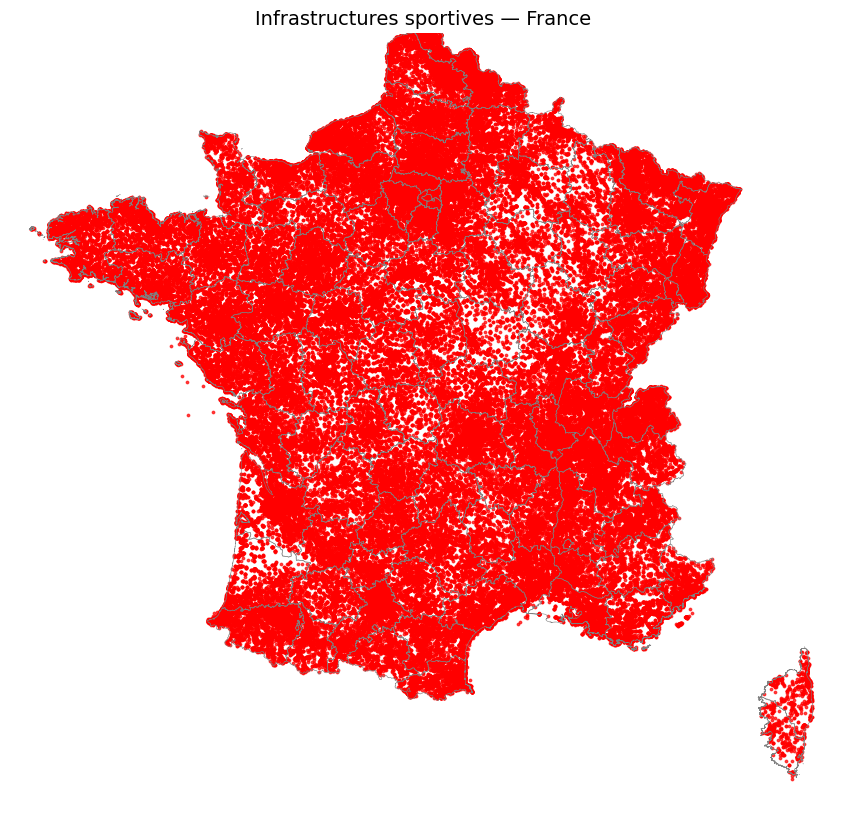

In [102]:
gdf_pts = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["equip_x"], df_final["equip_y"]),
    crs="EPSG:4326"
)


fig, ax = plt.subplots(figsize=(20, 10))
gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, color="red")
ax.set_xlim(-5.5, 10) 
ax.set_ylim(41, 51)
ax.set_title("Infrastructures sportives — France", fontsize=14)
ax.set_axis_off()
plt.savefig('docs/premiere_carte.png', dpi=300, bbox_inches='tight')

On voit que le schéma de la "diagonale du vide" semble se reproduire avec les infrastructures sportives.
La densité des infrastructures sportives en Corse semble moins importante qu'en France métropolitaine.

In [ ]:
#Carte de chaleur 


df = df_final.copy().dropna(subset=['equip_x', 'equip_y'])  #Supression des valeurs manquantes

#Création de la carte, centrée sur la France
calor = folium.Map(
    location=[46.5, 2.5],
    zoom_start=6,
    tiles='CartoDB positron'
)

#Récupération des données géographiques
heat_data = [[row['equip_y'], row['equip_x']] for idx, row in df.iterrows()]


#On complète la carte
HeatMap(
    heat_data,
    radius=15,           # Rayon de chaque point
    blur=20,             # Flou pour adoucir
    max_zoom=13,         # Zoom maximum
    gradient={            # Dégradé de couleurs personnalisé
        0.0: 'blue',
        0.3: 'lime',
        0.5: 'yellow',
        0.7: 'orange',
        1.0: 'red'
    }
).add_to(calor)
calor.save('docs/heatmap_toutes_infrastructures.html') #On sauvegarde la carte

In [105]:
def carte_interactive(df, info_couleur, titre_legende, info_survol, chemin_sauvegarde):
    """

    Affiche un graphique et un tableau côte à côte à partir d'un DataFrame à 2 colonnes
    
    Paramètre
    ----------
    df : DataFrame
        DataFrame contenant les informations à représenter sur la carte interactive
        
    info_couleur : str
        Nom de la variable du DataFrame selon laquelle on veut colorer la carte

    titre_legende : str
        Titre de la légende de couleurs

    info_survol : list
        Liste des variables (str) pour lesquelles on veut afficher les informations au survol de la souros

    chemin_sauvegarde : str
        Endroit où l'on veut sauvegarder la carte
    """

    #On copie le fond de carte pour ne pas le modifier directement
    gd = gdf.copy()
    
    
    #Fusion des données selon les codes de département
    gd = gd.merge(                 
    infra_par_dept, 
    left_on='INSEE_DEP', 
    right_on='dep_code', 
    how='left'
    )

    #Création de la carte, centrée sur la France
    m = folium.Map(
        location=[46.5, 2.5],
        zoom_start=6,
        tiles='CartoDB positron'
    )

    #On complète la carte
    folium.Choropleth(
        geo_data=gd,
        name='choropleth',
        data=df,
        columns=['dep_code', info_couleur],
        key_on='feature.properties.INSEE_DEP',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=titre_legende
    ).add_to(m)


    #Ajout des informations au survol de la souris
    folium.GeoJson(
        gd,
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
        tooltip=folium.GeoJsonTooltip(
            fields=['INSEE_DEP'] + info_survol,
            localize=True
        )
    ).add_to(m)
    m.save(chemin_sauvegarde)

In [106]:
def format_dept_code(code):
    """
    Ajouter un zéro devant les codes à 1 chiffre (1 → 01)
    """
    if code in ['2A', '2B']:
        return code
    if int(code) >= 10:
        return code
    else:
        return "0" + code

In [107]:
#On crée une carte qui compte le nombre d'infrastructures sportives par département

infra_par_dept = df_final.copy().groupby('dep_code').size().reset_index(name="Nombre d'infrastructures")

#On réadapte les codes de département pour correspondre au fond de carte
infra_par_dept['dep_code'] = infra_par_dept['dep_code'].astype(str)
infra_par_dept['dep_code'] = infra_par_dept['dep_code'].replace({
    '96': '2A',
    '97': '2B'
})


infra_par_dept['dep_code'] = infra_par_dept['dep_code'].apply(format_dept_code)
print("-" * 50)
print("Visualisation de la base de données infra_par_dept")
print("-" * 50)
print(infra_par_dept.head(4))

carte_interactive(infra_par_dept, "Nombre d'infrastructures", "Nombres d'infrastructures sportives",
                  ["Nombre d'infrastructures"], 'docs/carte_departements.html')

--------------------------------------------------
Visualisation de la base de données infra_par_dept
--------------------------------------------------
  dep_code  Nombre d'infrastructures
0       01                      3898
1       02                      3202
2       03                      2218
3       04                      1582


On observe sur cette carte que la Moselle et le Nord sont les départements comptant le plus grand nombre d’infrastructures sportives, tandis que les deux départements corses en disposent nettement moins.
Cependant, cette lecture doit être nuancée : la carte ne tient pas compte du nombre d’habitants ni du revenu médian de chaque département, deux facteurs essentiels pour interpréter correctement ces écarts.
Observons maintenant l'effet de la population sur cette carte.

In [108]:
#Estimation du nombre d'habitants par département avec les communes disponibles dans la base de données
pop_par_dept = df_final.copy()[['dep_code', 'new_code', 'P22_POP']].drop_duplicates(
    subset=['new_code']
).groupby('dep_code')['P22_POP'].sum().reset_index()


pop_par_dept['dep_code'] = pop_par_dept['dep_code'].astype(str)
pop_par_dept['dep_code'] = pop_par_dept['dep_code'].replace({
    '96': '2A',
    '97': '2B'
})

pop_par_dept.columns = ['dep_code', 'Population totale']
pop_par_dept['dep_code'] = pop_par_dept['dep_code'].apply(format_dept_code)

infra_par_dept = infra_par_dept.merge(pop_par_dept, on='dep_code', how='left')

infra_par_dept['Infrastructures pour 10000 habitants'] = (
    infra_par_dept["Nombre d'infrastructures"] / infra_par_dept['Population totale'] * 10000
).round(2) #Calcul du nombre d'infrastructures pour 10000 habitants

print("-" * 50)
print("Visualisation de la base de données infra_par_dept")
print("-" * 50)
print(infra_par_dept.head(4))


carte_interactive(infra_par_dept, 'Infrastructures pour 10000 habitants', 'Infrastructures sportives pour 10000 habitants', 
                  ["Nombre d'infrastructures", "Population totale", "Infrastructures pour 10000 habitants"],
                  'docs/carte_infra_par_habitant.html')

--------------------------------------------------
Visualisation de la base de données infra_par_dept
--------------------------------------------------
  dep_code  Nombre d'infrastructures  Population totale  \
0       01                      3898           667641.0   
1       02                      3202           481628.0   
2       03                      2218           327604.0   
3       04                      1582           163403.0   

   Infrastructures pour 10000 habitants  
0                                 58.38  
1                                 66.48  
2                                 67.70  
3                                 96.82  


Le résultat change totalement puisque c'est désormais les Hautes Alpes qui détiennent le plus d'infrastructures sportives par 10 000 habitants.

On va maintenant passer à des statistiques descriptives numériques 

In [109]:
print(f"Il y a {df_final["equip_type_name"].count()} infrastructures sportives dans notre base de données")

Il y a 285172 infrastructures sportives dans notre base de données


In [110]:
print("Voici le type d'infrastructures qu'on retrouve dans notre base de données : \n \n")
df_final.copy()["equip_type_name"].value_counts().reset_index().head(15)


Voici le type d'infrastructures qu'on retrouve dans notre base de données : 
 



equip_type_name  count
0                                  Terrain de football  33315
1                                      Court de tennis  23271
2                              Multisports/City-stades  23077
3                                  Boucle de randonnée  21958
4                          Salle multisports (gymnase)  18068
5                                  Terrain de pétanque  17749
6   Salles polyvalentes / des fêtes / non spécialisées  15638
7                  Salle de musculation/cardiotraining   7104
8                               Terrain de basket-ball   7009
9                                             Carrière   6973
10                        Dojo / Salle d'arts martiaux   6176
11                                   Terrain de boules   5547
12                                              Manège   4139
13                           Piste d'athlétisme isolée   4085
14                           Salle de cours collectifs   3704

Nous pouvons créer des cartes pour les principaux sports:

In [111]:
gdf_pts = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["equip_x"], df_final["equip_y"]),
    crs="EPSG:4326"
)

cartes_a_faire = [
    {
        "filtre": "Terrain de football", 
        "fichier": "docs/carte_football.png", 
        "titre": "Terrains de Football", 
        "couleur": "green"
    },
    {
        "filtre": "Court de tennis", 
        "fichier": "docs/tennis.png", 
        "titre": "Courts de Tennis", 
        "couleur": "orange"
    },
    {
        "filtre": "Multisports/City-stades", 
        "fichier": "docs/City_stades.png", 
        "titre": "City-stades / Multisports", 
        "couleur": "blue"
    },
        {
        "filtre": "Rugby", 
        "fichier": "docs/rugby.png", 
        "titre": "Rugby", 
        "couleur": "brown"
    }
]

for config in cartes_a_faire:
    print(f"Génération de la carte : {config['titre']}...")
    
    subset = gdf_pts[gdf_pts["equip_type_name"].str.contains(config["filtre"], case=False, regex=False, na=False)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
    
    subset.plot(ax=ax, markersize=2, alpha=0.7, color=config["couleur"])
    ax.set_xlim(-5.5, 10) 
    ax.set_ylim(41, 51)
    ax.set_title(f"{config['titre']} — France (N={len(subset)})", fontsize=14)
    ax.set_axis_off()
    plt.savefig(config["fichier"], dpi=300, bbox_inches='tight')
    
    plt.close()

Génération de la carte : Terrains de Football...
Génération de la carte : Courts de Tennis...
Génération de la carte : City-stades / Multisports...
Génération de la carte : Rugby...


In [112]:
infra_par_commune = (
    df_final.copy().groupby("new_code")
            .size()
            .reset_index(name="Nombre d'infrastructures par commune")
)

infra_par_commune.describe()

Nombre d'infrastructures par commune
count                          28311.000000
mean                              10.072869
std                               23.271691
min                                1.000000
25%                                2.000000
50%                                5.000000
75%                               10.000000
max                             1542.000000

In [113]:
communes_ref = df_final.copy()[['new_code', 'new_name']].drop_duplicates()
infra_par_commune = infra_par_commune.merge(
    communes_ref,
    on="new_code",
    how="left"
)
infra_par_commune.sort_values("Nombre d'infrastructures par commune", ascending=False).head(10)

new_code  Nombre d'infrastructures par commune     new_name
9359     31555                                  1542     Toulouse
13247    44109                                   658       Nantes
15071    51454                                   652        Reims
21348    67482                                   516   Strasbourg
22991    72181                                   515      Le Mans
10316    34172                                   507  Montpellier
8146     29019                                   499        Brest
14350    49007                                   499       Angers
5466     21231                                   453        Dijon
8784     30189                                   418        Nîmes

In [114]:
arrondissements_paris = df_final.copy()[
    df_final["new_code"].astype(str).between("75100", "75120")
]

infra_par_arrdt_Paris = (
    arrondissements_paris
    .groupby("new_name")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

arrondissements_marseille = df_final.copy()[
    df_final["new_code"].astype(str).between("13201", "13216")
]

infra_par_arrdt_Marseille = (
    arrondissements_marseille
    .groupby("new_name")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

# Arrondissements de Lyon : 69381 à 69389
arrondissements_lyon = df_final.copy()[
    df_final["new_code"].astype(str).between("69381", "69389")
]

infra_par_arrdt_Lyon = (
    arrondissements_lyon
    .groupby("new_name")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

total_paris = infra_par_arrdt_Paris["Nombre d'infrastructures"].sum()
total_lyon = infra_par_arrdt_Lyon["Nombre d'infrastructures"].sum()
total_marseille = infra_par_arrdt_Marseille["Nombre d'infrastructures"].sum()

print("Total Paris :", total_paris)
print("Total Lyon :", total_lyon)
print("Total Marseille :", total_marseille)

villes_majeures = pd.DataFrame([
    {"new_code": "75056", "Nombre d'infrastructures par commune": total_paris,      "new_name": "Paris"},
    {"new_code": "69123", "Nombre d'infrastructures par commune": total_lyon,       "new_name": "Lyon"},
    {"new_code": "13055", "Nombre d'infrastructures par commune": total_marseille,  "new_name": "Marseille"},
])
infra_par_commune = pd.concat([infra_par_commune, villes_majeures], ignore_index=True)

infra_par_commune.sort_values("Nombre d'infrastructures par commune", ascending=False).head(10)




Total Paris : 2643
Total Lyon : 790
Total Marseille : 1194


new_code  Nombre d'infrastructures par commune     new_name
28319    75056                                  2643        Paris
9359     31555                                  1542     Toulouse
28321    13055                                  1194    Marseille
28320    69123                                   790         Lyon
13247    44109                                   658       Nantes
15071    51454                                   652        Reims
21348    67482                                   516   Strasbourg
22991    72181                                   515      Le Mans
10316    34172                                   507  Montpellier
8146     29019                                   499        Brest

Le résultat donnée nous semble un peu plus logique car ce sont les 3 villes les plus peuplées de France et il semblait bizarre de ne pas les voir dans le classement précédent. Paris est donc de loin la ville avec le plus d'infrastructures. Un question légitime (en connaissant la ville) est de se demander lesquelles sont-elles?

In [115]:
df_paris = df_final.copy()
df_paris = df_paris[
    df_paris["new_code"].astype(str).between("75101", "75120")
]

top_equipements_paris = (
    df_paris["equip_type_name"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Nombre"})
    .head(10)
)

top_equipements_paris

equip_type_name  Nombre
0                 Salle de musculation/cardiotraining     322
1                         Salle multisports (gymnase)     321
2                                     Court de tennis     292
3                           Salle de cours collectifs     208
4                             Multisports/City-stades     202
5                                      Salle de danse     191
6                        Dojo / Salle d'arts martiaux     115
7  Salles polyvalentes / des fêtes / non spécialisées     102
8                              Terrain de basket-ball      86
9                                 Terrain de football      69

In [116]:
infra_par_dept.sort_values("Nombre d'infrastructures", ascending=False)

dep_code  Nombre d'infrastructures  Population totale  \
57       59                      7615          2601793.0   
55       57                      6736          1037748.0   
29       31                      5974          1436121.0   
42       44                      5835          1473156.0   
62       64                      5577           696235.0   
..      ...                       ...                ...   
21       23                       990           101536.0   
56       58                       990           176769.0   
88       90                       729           136450.0   
95       2B                       670           173158.0   
94       2A                       471           156809.0   

    Infrastructures pour 10000 habitants  
57                                 29.27  
55                                 64.91  
29                                 41.60  
42                                 39.61  
62                                 80.10  
..                                   ...  
21                                 97.50  
56                                 56.01  
88                                 53.43  
95                                 38.69  
94                                 30.04  

[96 rows x 4 columns]

In [117]:
infra_par_dept.sort_values("Infrastructures pour 10000 habitants", ascending=False)

dep_code  Nombre d'infrastructures  Population totale  \
4        05                      3136           141282.0   
46       48                      1355            74717.0   
8        09                      1766           150086.0   
14       15                      1586           140786.0   
44       46                      1838           172521.0   
..      ...                       ...                ...   
12       13                      4877          2069583.0   
92       94                      2455          1419531.0   
90       92                      2785          1647435.0   
91       93                      2390          1681725.0   
73       75                      2643          2113705.0   

    Infrastructures pour 10000 habitants  
4                                 221.97  
46                                181.35  
8                                 117.67  
14                                112.65  
44                                106.54  
..                                   ...  
12                                 23.57  
92                                 17.29  
90                                 16.91  
91                                 14.21  
73                                 12.50  

[96 rows x 4 columns]

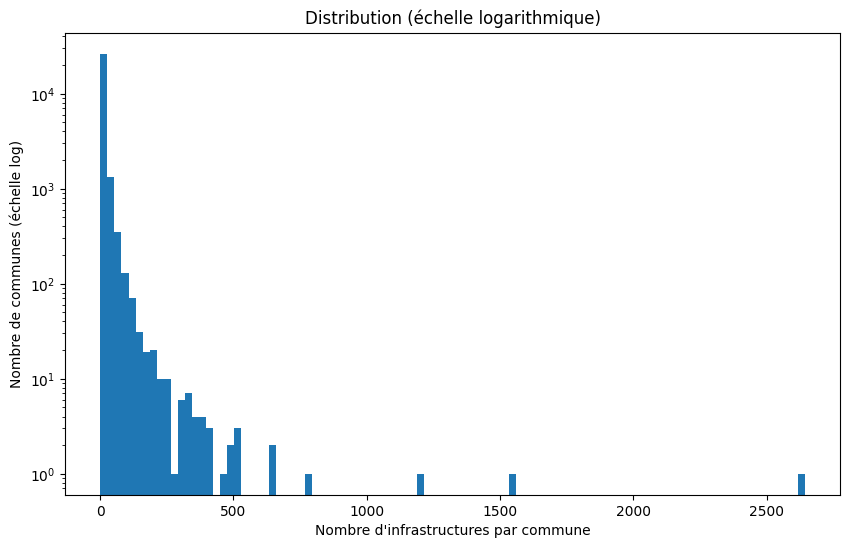

In [118]:
plt.figure(figsize=(10,6))
plt.hist(infra_par_commune["Nombre d'infrastructures par commune"], bins=100)
plt.yscale("log")
plt.xlabel("Nombre d'infrastructures par commune")
plt.ylabel("Nombre de communes (échelle log)")
plt.title("Distribution (échelle logarithmique)")
plt.show()




Le graphique obtenu ressemble la densité d'une loi exponentielle: Toutes les valeurs sont positives mais la décroissance est très forte avec juste quelques extrêmes.

In [119]:
infra_par_densite = (
    df_final.copy().groupby("dens_lib")
            .size()
            .reset_index(name="Nombre d'infrastructures")
)
infra_par_densite = infra_par_densite.sort_values("Nombre d'infrastructures", ascending=False)
infra_par_densite

dens_lib  Nombre d'infrastructures
5        Rural à habitat dispersé                     73604
0                   Bourgs ruraux                     62619
3          Grands centres urbains                     54616
2  Centres urbains intermédiaires                     30293
1              Ceintures urbaines                     26752
4                  Petites villes                     20451
6   Rural à habitat très dispersé                     16838

Selon la classification de l’INSEE, les communes rurales concentrent le plus grand nombre d’infrastructures sportives en valeur absolue, notamment les catégories « Rural à habitat dispersé » et « Bourgs ruraux ». Ce résultat s’explique principalement par le fait que les communes rurales représentent la grande majorité des communes françaises. Les grands centres urbains totalisent également beaucoup d’équipements, mais restent derrière car ils sont moins nombreux. Ainsi, cette répartition reflète surtout le nombre de communes par catégorie, davantage que leur niveau réel d’équipement moyen.

In [120]:
def tab_barplot(df, titre):
    """
    Affiche un graphique et un tableau côte à côte à partir d'un DataFrame à 2 colonnes
    
    Paramètre
    ----------
    df : DataFrame
        DataFrame à deux colonnes
        
    titre : str
        Titre de la figure
    """
    fig = plt.figure(figsize = (16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)


    #Création du barplot
    ax1.bar(
    df[df.columns[0]], 
    df[df.columns[1]]
    )
    ax1.set_xlabel(df.columns[0])
    ax1.set_ylabel(df.columns[1])



    #Création du tableau
    ax2.axis('off')

    table = ax2.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        colWidths=[0.4, 0.6]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2) 

    fig.suptitle(titre)

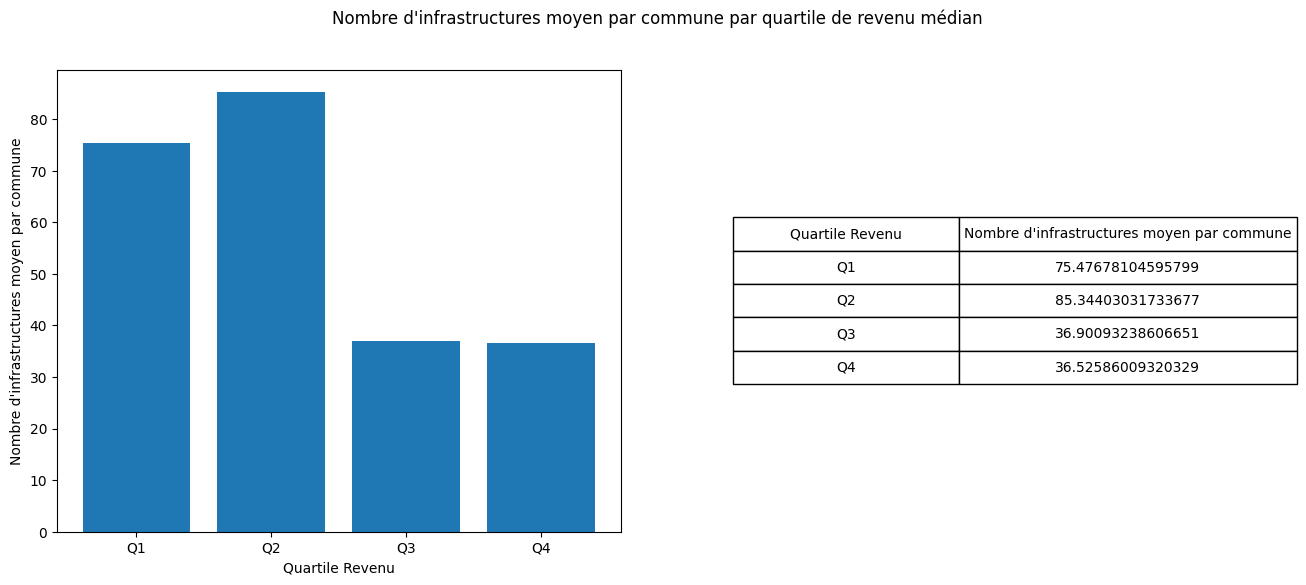

In [121]:
df_med = infra_par_commune.merge(
    df_final.copy()[["new_name", "MED21"]],
    on= "new_name",
    how="left"
)


df_med["Quartile Revenu"] = pd.qcut(
    df_med["MED21"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

infra_par_quartile = (
    df_med.groupby("Quartile Revenu", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_quartile.columns = ["Quartile Revenu", "Nombre d'infrastructures moyen par commune"]

tab_barplot(infra_par_quartile, "Nombre d'infrastructures moyen par commune par quartile de revenu médian")

D’après la distribution en quartiles du revenu médian des communes, on observe une relation contrastée entre niveau de vie et nombre d’infrastructures sportives. Les communes situées dans les quartiles Q1 et Q2 - les territoires les plus modestes - disposent en moyenne du plus grand nombre d’équipements, autour de 80 à 90 infrastructures par commune. À l’inverse, les communes appartenant aux quartiles Q3 et surtout Q4 (les plus aisées) présentent des moyennes nettement plus faibles, autour de 40 infrastructures. Cette répartition suggère que les territoires moins favorisés accueillent proportionnellement davantage d’infrastructures sportives que les plus riches, sans doute en raison de leur poids démographique ou de logiques d’aménagement spécifiques.

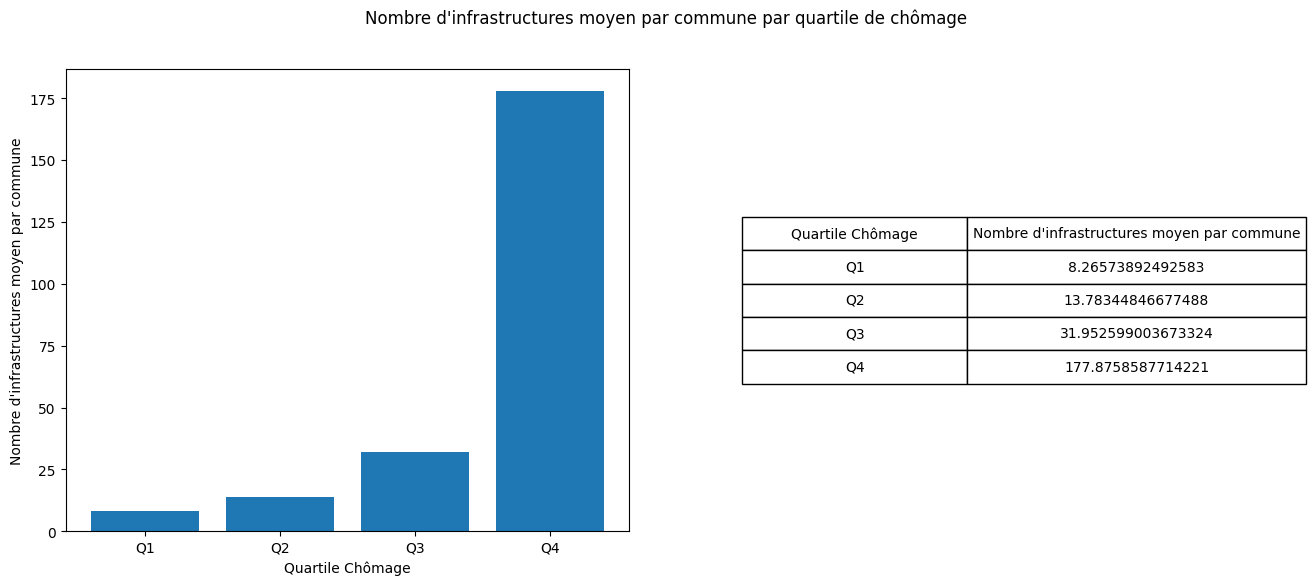

In [122]:
df_chom = infra_par_commune.merge(
    df_final.copy()[["new_name", "P22_CHOM1564"]],
    on= "new_name",
    how="left"
)


df_chom["Quartile Chômage"] = pd.qcut(
    df_chom["P22_CHOM1564"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

infra_par_quartile_chom = (
    df_chom.groupby("Quartile Chômage", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_quartile_chom.columns = ["Quartile Chômage", "Nombre d'infrastructures moyen par commune"]
tab_barplot(infra_par_quartile_chom, "Nombre d'infrastructures moyen par commune par quartile de chômage")

L’analyse par quartiles du taux de chômage montre une relation positive à celle observée avec le revenu médian. Ici, les communes les plus touchées par le chômage (quartile Q4) concentrent en moyenne beaucoup plus d’infrastructures sportives, près de 170 par commune, contre seulement 9 à 15 dans les quartiles les plus faibles (Q1–Q2). L’étude du revenu médian révélait de la même manière que les communes les plus aisées étaient plutôt moins dotées en infrastructures. Ces résultats suggèrent qu’une partie importante de l’offre sportive se situe dans des territoires plus fragiles socio-économiquement, où le niveau de chômage est élevé et les revenus plus faibles.

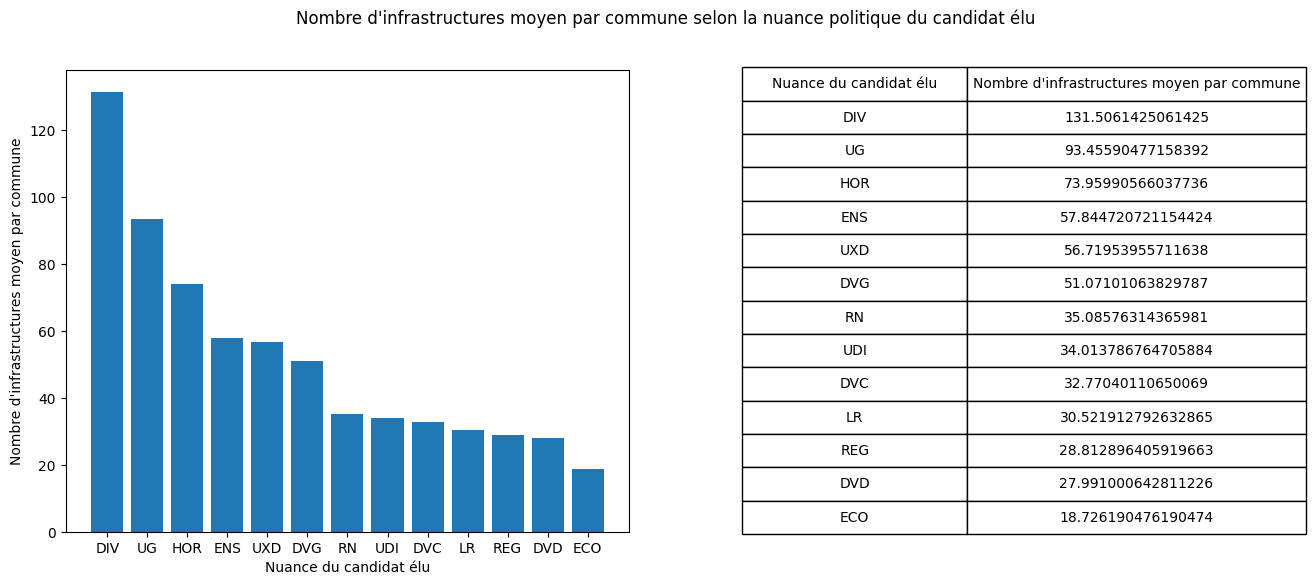

In [123]:
df_pol = infra_par_commune.merge(
    df_final.copy()[["new_name", "Nuance candidat élu"]],
    on= "new_name",
    how="left"
)


infra_par_pol= (
    df_pol.groupby("Nuance candidat élu", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_pol.columns = ["Nuance du candidat élu", "Nombre d'infrastructures moyen par commune"]
infra_par_pol = infra_par_pol.sort_values("Nombre d'infrastructures moyen par commune", ascending=False)

tab_barplot(infra_par_pol, "Nombre d'infrastructures moyen par commune selon la nuance politique du candidat élu")

La comparaison du nombre moyen d’infrastructures sportives selon la nuance du candidat élu en 2024 montre des écarts importants entre territoires. Les communes ayant élu un candidat classé DIV, UG ou HOR apparaissent en moyenne nettement plus dotées en équipements que celles administrées par des élus LR, REG, DVD ou ECO. Toutefois, cette lecture doit être fortement nuancée : l’élection de 2024 n’a eu quasiment aucun impact sur la présence d’infrastructures sportives, puisque celles-ci résultent d’investissements réalisés sur de longues périodes. Les différences observées reflètent donc avant tout les caractéristiques socio-économiques des territoires où ces nuances politiques sont dominantes, plutôt qu’un effet direct de l’orientation politique des élus élus en 2024.

IV/ Modélisation

On va maintenant faire la partie modélisation.

In [124]:
#On transforme notre base de données pour faire des régressions

infra_count = df_final.groupby('new_code').size().reset_index(name='Nb_infrastructures')

autres_vars = df_final.groupby('new_code').first().reset_index()

df_commune = autres_vars.merge(infra_count, on='new_code', how='left')

df_commune.head(6)


new_code  inst_cp                 new_name  dep_code  \
0    01001     1400  L'Abergement-Clémenciat         1   
1    01002     1640    L'Abergement-de-Varey         1   
2    01004     1500        Ambérieu-en-Bugey         1   
3    01005     1330      Ambérieux-en-Dombes         1   
4    01006     1300                  Ambléon         1   
5    01007     1500                 Ambronay         1   

                                                                   aps_name  \
0                                                        Randonnée pédestre   
1                                                               Spéléologie   
2                                                               Spéléologie   
3  Autres Danses,Badminton,Jeu de volant,Gymnastique volontaire,Tir à l'arc   
4                                                               Spéléologie   
5                                                               Tir à l'arc   

                         dens_lib  \
0        Rural à habitat dispersé   
1        Rural à habitat dispersé   
2  Centres urbains intermédiaires   
3                   Bourgs ruraux   
4        Rural à habitat dispersé   
5        Rural à habitat dispersé   

                                      equip_type_name  equip_x   equip_y  \
0                                 Boucle de randonnée  4.92138  46.15111   
1                    Espace de pratique spéléologique  5.42575  46.00541   
2        Site de spéléologie sportive et/ou éducative  5.38741  45.95732   
3  Salles polyvalentes / des fêtes / non spécialisées  4.90140  45.99860   
4                    Espace de pratique spéléologique  5.60138  45.74944   
5                                  Pas de tir à l'arc  5.32754  46.03418   

   P22_POP      P22_MEN  MED21 TP6021  P22_CHOM1564 Nuance candidat élu  \
0    859.0   354.000000  25820      s     28.000000                  RN   
1    273.0   121.000000  24480      s      2.000000                 UXD   
2  15554.0  7107.012476  21660   17,0   1005.744641                 UXD   
3   1917.0   814.669985  24610      s     63.323397                  RN   
4    114.0    57.000000  24210      s      5.000000                 ENS   
5   2828.0  1207.205453  24860      s    105.671492                 UXD   

   Nb_infrastructures  
0                   6  
1                   1  
2                  53  
3                  12  
4                   1  
5                  15

In [125]:
#On renomme les variables pour ne pas avoir d'erreurs avec statsmodels (accents et espaces)
df_commune = df_commune.rename(columns={
    "Nuance candidat élu": "Nuance_candidat",
    "dens_lib": "Densite"
})

In [126]:
#Determinants du nombre d'infrastructures
model = smf.ols('Nb_infrastructures ~ P22_POP + MED21 + C(Nuance_candidat) + C(Densite)', data = df_commune.dropna()).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Nb_infrastructures   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     532.0
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:13:30   Log-Likelihood:                -91074.
No. Observations:               24095   AIC:                         1.822e+05
Df Residuals:                   24074   BIC:                         1.824e+05
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

L’analyse montre que la couleur politique du député élu en 2024 n’a pas d’impact significatif sur le nombre d’infrastructures sportives, ce qui s’explique par des décisions d’aménagement prises sur le long terme.​
En revanche, la densité du territoire apparaît comme un facteur déterminant dans plusieurs types d’espaces (urbains et ruraux), influençant la répartition des équipements.​
La population en 2022 joue également un rôle majeur : plus un territoire compte d’habitants, plus il tend à disposer d’un parc sportif développé.​
Le revenu médian de 2021 intervient lui aussi, car d'après la régression, une hausse de 1€ du revenu médian diminue le nombre d'infrastructures d'une commune de 0,0004. 
Concentrons nous sur ces 2 dernières variables:

In [127]:
model2 = smf.ols('Nb_infrastructures ~ P22_POP + MED21', data = df_commune.dropna()).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité

print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:     Nb_infrastructures   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     119.1
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           3.22e-52
Time:                        14:13:34   Log-Likelihood:                -92431.
No. Observations:               24095   AIC:                         1.849e+05
Df Residuals:                   24092   BIC:                         1.849e+05
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4048      0.549     18.953      0.0

On constate qu'à eux seuls, le revenu médian de 2021 et la population en 2022 expliquent 78% des infrastructures sportives en France. On peut, à partir de ces deux variables, construire une carte théorique des équipements sportifs en France.

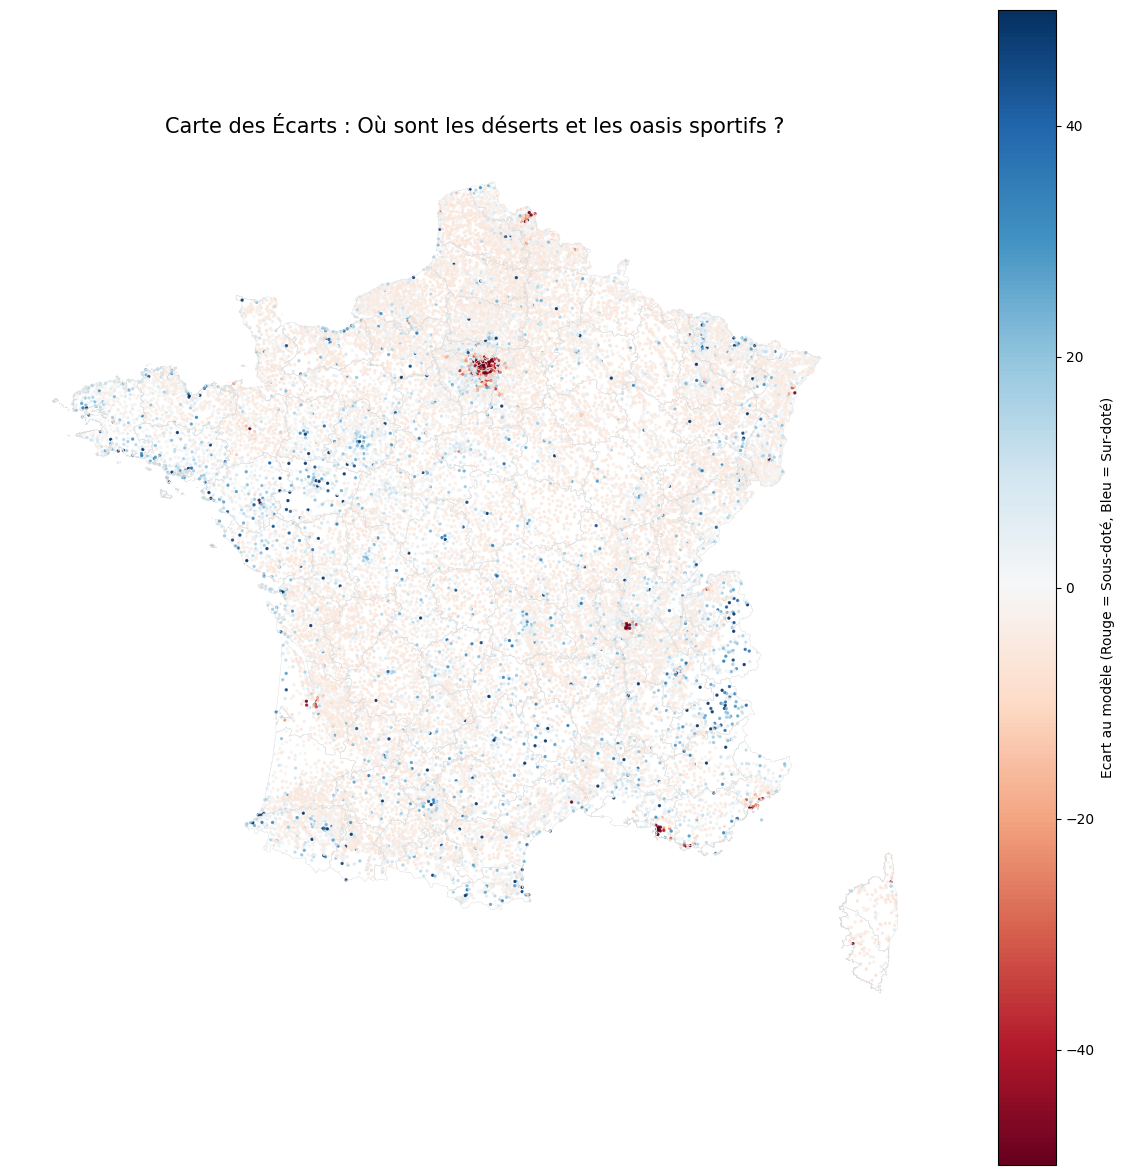

In [128]:
df_reg = df_final.groupby("new_code").agg({
    "new_code": "count",       
    "P22_POP": "first",       
    "MED21": "first",         
    "equip_x": "first",       
    "equip_y": "first"
}).rename(columns={"new_code": "nb_reel"}).reset_index()

df_reg = df_reg.dropna(subset=["P22_POP", "MED21"])

df_reg["nb_theorique"] = 10.4022 + (0.0023 * df_reg["P22_POP"]) - (0.0002 * df_reg["MED21"])

df_reg["ecart"] = df_reg["nb_reel"] - df_reg["nb_theorique"]

gdf_analyse = gpd.GeoDataFrame(
    df_reg,
    geometry=gpd.points_from_xy(df_reg["equip_x"], df_reg["equip_y"]),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(15, 15))
gdf.boundary.plot(ax=ax, linewidth=0.3, color="gray") # Fond de carte
gdf_analyse.plot(
    ax=ax,
    column="nb_theorique",
    cmap="viridis",
    markersize=2,
    alpha=0.6,
    legend=True,
    legend_kwds={'label': "Nombre d'équipements prédit par le modèle"}
)
ax.set_title("Carte Théorique : Équipements prédits par la Population et le Revenu", fontsize=15)
ax.set_axis_off()
plt.savefig('docs/carte_theorique.png', dpi=300, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(figsize=(15, 15))
gdf.boundary.plot(ax=ax, linewidth=0.3, color="#dddddd")

gdf_analyse.plot(
    ax=ax,
    column="ecart",
    cmap="RdBu",  # Rouge = Moins que prévu / Bleu = Plus que prévu
    vmin=-50,     
    vmax=50,
    markersize=2,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': "Ecart au modèle (Rouge = Sous-doté, Bleu = Sur-doté)"}
)
ax.set_title("Carte des Écarts : Où sont les déserts et les oasis sportifs ?", fontsize=15)
ax.set_axis_off()
plt.savefig('docs/carte_ecarts.png', dpi=300, bbox_inches='tight')


Si on se concentre uniquement sur la population:

In [129]:
model3 = smf.ols('Nb_infrastructures ~ P22_POP', data = df_commune).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité


print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:     Nb_infrastructures   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     246.5
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           2.56e-55
Time:                        14:13:56   Log-Likelihood:            -1.0928e+05
No. Observations:               28264   AIC:                         2.186e+05
Df Residuals:                   28262   BIC:                         2.186e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2603      0.272     19.346      0.0

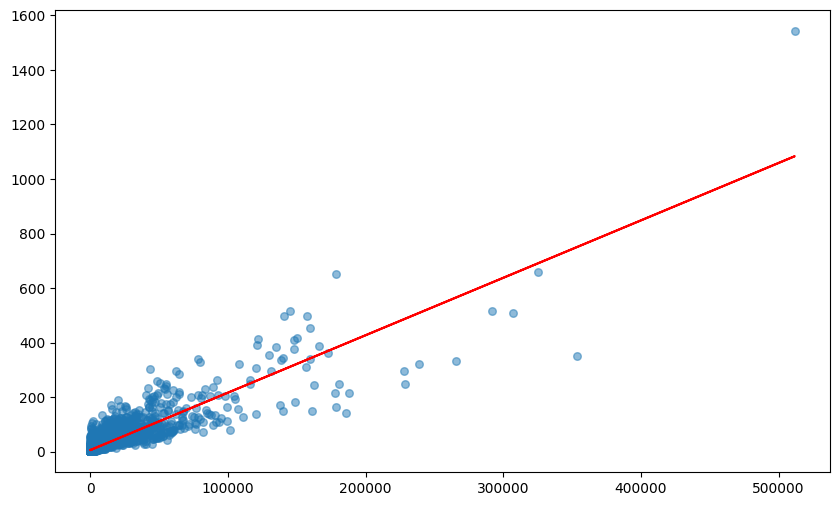

In [130]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1, 1, 1)

# Nuage de points
ax.scatter(df_commune['P22_POP'], df_commune['Nb_infrastructures'], 
           alpha=0.5, s=30, label='Observations')
ax.plot(df_commune['P22_POP'].dropna(), model3.predict(), color = "Red", label = "Droite de régression")


Cela nous incite à créer une nouvelle variable dans notre base de données : nombre d'infrastructures pour 10 000 habitants

In [131]:
df_commune["infra_10k"] = (df_commune["Nb_infrastructures"] / df_commune["P22_POP"]) * 10000
df_commune.head(6)

new_code  inst_cp                 new_name  dep_code  \
0    01001     1400  L'Abergement-Clémenciat         1   
1    01002     1640    L'Abergement-de-Varey         1   
2    01004     1500        Ambérieu-en-Bugey         1   
3    01005     1330      Ambérieux-en-Dombes         1   
4    01006     1300                  Ambléon         1   
5    01007     1500                 Ambronay         1   

                                                                   aps_name  \
0                                                        Randonnée pédestre   
1                                                               Spéléologie   
2                                                               Spéléologie   
3  Autres Danses,Badminton,Jeu de volant,Gymnastique volontaire,Tir à l'arc   
4                                                               Spéléologie   
5                                                               Tir à l'arc   

                          Densite  \
0        Rural à habitat dispersé   
1        Rural à habitat dispersé   
2  Centres urbains intermédiaires   
3                   Bourgs ruraux   
4        Rural à habitat dispersé   
5        Rural à habitat dispersé   

                                      equip_type_name  equip_x   equip_y  \
0                                 Boucle de randonnée  4.92138  46.15111   
1                    Espace de pratique spéléologique  5.42575  46.00541   
2        Site de spéléologie sportive et/ou éducative  5.38741  45.95732   
3  Salles polyvalentes / des fêtes / non spécialisées  4.90140  45.99860   
4                    Espace de pratique spéléologique  5.60138  45.74944   
5                                  Pas de tir à l'arc  5.32754  46.03418   

   P22_POP      P22_MEN  MED21 TP6021  P22_CHOM1564 Nuance_candidat  \
0    859.0   354.000000  25820      s     28.000000              RN   
1    273.0   121.000000  24480      s      2.000000             UXD   
2  15554.0  7107.012476  21660   17,0   1005.744641             UXD   
3   1917.0   814.669985  24610      s     63.323397              RN   
4    114.0    57.000000  24210      s      5.000000             ENS   
5   2828.0  1207.205453  24860      s    105.671492             UXD   

   Nb_infrastructures  infra_10k  
0                   6  69.848661  
1                   1  36.630037  
2                  53  34.074836  
3                  12  62.597809  
4                   1  87.719298  
5                  15  53.041018

In [132]:
model = smf.ols('infra_10k ~ MED21 + C(Nuance_candidat) + C(Densite)', data = df_commune.dropna()).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              infra_10k   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     248.6
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:14:11   Log-Likelihood:            -1.4551e+05
No. Observations:               24095   AIC:                         2.911e+05
Df Residuals:                   24075   BIC:                         2.912e+05
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

Sans prendre en compte la population en 2022, le R^2 chute et ne vaut seulement 0,08. 

In [133]:
df_cluster = df_commune.copy()
df_cluster = df_cluster.dropna()

df_cluster = pd.get_dummies(df_cluster, 
                            columns=["Densite"], 
                            drop_first=False)

vars_clustering = [col for col in df_cluster.columns 
                   if col.startswith("Densite_")] + [
    "Nb_infrastructures", "MED21", "P22_POP"
]

X = df_cluster[vars_clustering]


# standardisation (important)
X_scaled = StandardScaler().fit_transform(X)


# clustering en 4 groupes
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X_scaled)

df_cluster.head(6)

new_code  inst_cp                 new_name  dep_code  \
0    01001     1400  L'Abergement-Clémenciat         1   
1    01002     1640    L'Abergement-de-Varey         1   
2    01004     1500        Ambérieu-en-Bugey         1   
3    01005     1330      Ambérieux-en-Dombes         1   
4    01006     1300                  Ambléon         1   
5    01007     1500                 Ambronay         1   

                                                                   aps_name  \
0                                                        Randonnée pédestre   
1                                                               Spéléologie   
2                                                               Spéléologie   
3  Autres Danses,Badminton,Jeu de volant,Gymnastique volontaire,Tir à l'arc   
4                                                               Spéléologie   
5                                                               Tir à l'arc   

                                      equip_type_name  equip_x   equip_y  \
0                                 Boucle de randonnée  4.92138  46.15111   
1                    Espace de pratique spéléologique  5.42575  46.00541   
2        Site de spéléologie sportive et/ou éducative  5.38741  45.95732   
3  Salles polyvalentes / des fêtes / non spécialisées  4.90140  45.99860   
4                    Espace de pratique spéléologique  5.60138  45.74944   
5                                  Pas de tir à l'arc  5.32754  46.03418   

   P22_POP      P22_MEN  ...  Nb_infrastructures  infra_10k  \
0    859.0   354.000000  ...                   6  69.848661   
1    273.0   121.000000  ...                   1  36.630037   
2  15554.0  7107.012476  ...                  53  34.074836   
3   1917.0   814.669985  ...                  12  62.597809   
4    114.0    57.000000  ...                   1  87.719298   
5   2828.0  1207.205453  ...                  15  53.041018   

   Densite_Bourgs ruraux Densite_Ceintures urbaines  \
0                  False                      False   
1                  False                      False   
2                  False                      False   
3                   True                      False   
4                  False                      False   
5                  False                      False   

   Densite_Centres urbains intermédiaires  Densite_Grands centres urbains  \
0                                   False                           False   
1                                   False                           False   
2                                    True                           False   
3                                   False                           False   
4                                   False                           False   
5                                   False                           False   

   Densite_Petites villes  Densite_Rural à habitat dispersé  \
0                   False                              True   
1                   False                              True   
2                   False                             False   
3                   False                             False   
4                   False                              True   
5                   False                              True   

   Densite_Rural à habitat très dispersé  cluster  
0                                  False        0  
1                                  False        0  
2                                  False        2  
3                                  False        2  
4                                  False        0  
5                                  False        0  

[6 rows x 24 columns]

In [134]:
# Préparation des données
df_lasso = df_commune.copy()

# Variables numériques
vars_numeriques = ['P22_POP', 'MED21', 'P22_CHOM1564']

# Variables catégorielles
vars_categorielles = ['Nuance_candidat', 'Densite']

# Sélection des variables
colonnes = vars_numeriques + vars_categorielles + ['Nb_infrastructures']
df_lasso = df_lasso[colonnes].dropna()

#Création des variables binaires (drop_first=True évite la colinéarité)
df_avec_dummies = pd.get_dummies(
    df_lasso,
    columns=vars_categorielles,  
    drop_first=True,
    prefix=['Nuance', 'Den']
)

#Séparation pour standardiser X
y = df_avec_dummies['Nb_infrastructures']
X = df_avec_dummies.drop('Nb_infrastructures', axis=1)

#Standardisation X
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

lasso_cv = LassoCV(
    cv=10,              # 10-fold cross-validation
    random_state=42,
    max_iter=10000,
    n_alphas=100        # Teste 100 valeurs d'alpha différentes
)

# Entraînement
lasso_cv.fit(X_scaled, y)

coefficients = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': lasso_cv.coef_,
    'Coefficient_abs': np.abs(lasso_cv.coef_)
}).sort_values('Coefficient_abs', ascending=False)

print("Tous les coefficients (triés par importance) :")
coefficients


/opt/python/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


Tous les coefficients (triés par importance) :


Variable  Coefficient  Coefficient_abs
0                              P22_POP    18.500931        18.500931
16  Den_Centres urbains intermédiaires     2.128989         2.128989
19        Den_Rural à habitat dispersé    -2.013254         2.013254
20   Den_Rural à habitat très dispersé    -1.926203         1.926203
2                         P22_CHOM1564     1.760041         1.760041
1                                MED21    -1.055282         1.055282
18                  Den_Petites villes     0.971205         0.971205
17          Den_Grands centres urbains    -0.405524         0.405524
11                           Nuance_RN    -0.342593         0.342593
7                           Nuance_ENS     0.235204         0.235204
13                           Nuance_UG     0.111136         0.111136
5                           Nuance_DVG     0.105334         0.105334
14                          Nuance_UXD    -0.011471         0.011471
4                           Nuance_DVD    -0.000000         0.000000
3                           Nuance_DVC     0.000000         0.000000
12                          Nuance_UDI    -0.000000         0.000000
8                           Nuance_HOR     0.000000         0.000000
6                           Nuance_ECO     0.000000         0.000000
10                          Nuance_REG     0.000000         0.000000
9                            Nuance_LR    -0.000000         0.000000
15              Den_Ceintures urbaines    -0.000000         0.000000

In [135]:
#FAIRE UNE REGRESSION LOGISTIQUE AVEC LA PROBABILITE DETRE UN DESERT SPORTIF (TROUVER UN SEUIL ou <= Xinfra_10k = desert_sportif)

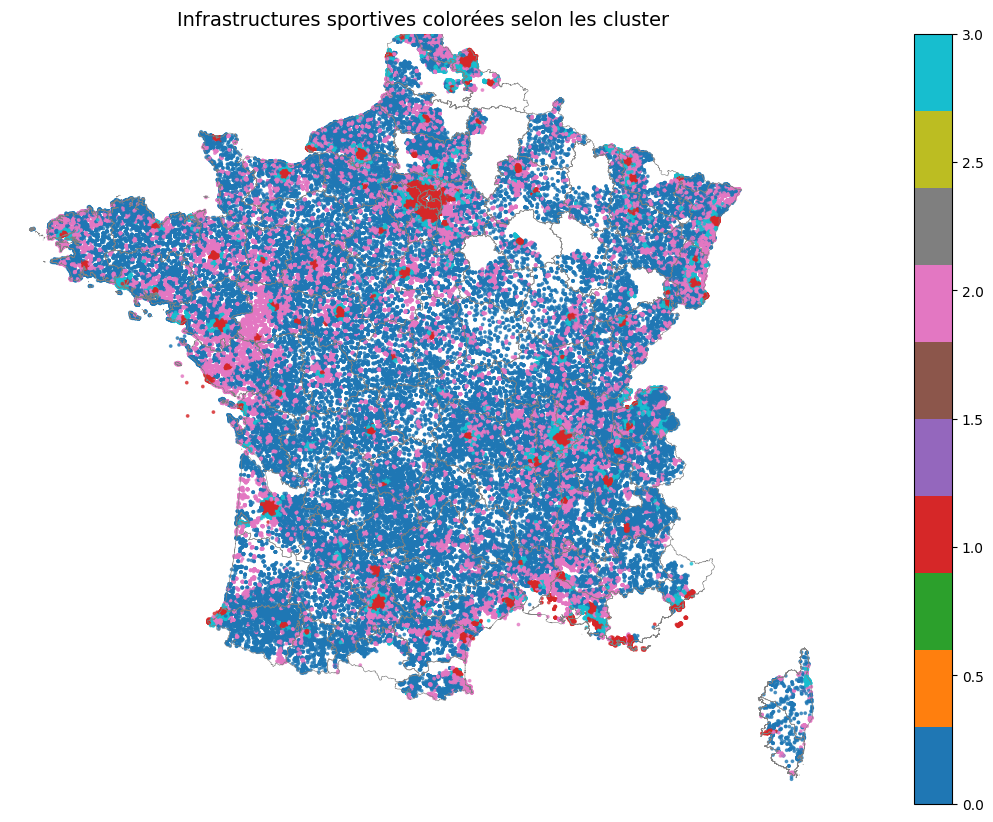

In [136]:
df_final_cluster = df_final.merge(
    df_cluster[["new_code", "cluster"]],
    on="new_code",
    how="left"
)

gdf_pts = gpd.GeoDataFrame(
    df_final_cluster,
    geometry=gpd.points_from_xy(df_final_cluster["equip_x"], df_final_cluster["equip_y"]),
    crs="EPSG:4326"
)


fig, ax = plt.subplots(figsize=(20, 10))
gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, column="cluster", cmap = "tab10", legend = True)
ax.set_xlim(-5.5, 10) 
ax.set_ylim(41, 51)
ax.set_title("Infrastructures sportives colorées selon les cluster", fontsize=14)
ax.set_axis_off()
plt.savefig('docs/carte_clusters.png', dpi=300, bbox_inches='tight')

In [137]:
#Je sais pas pourquoi il manque des points (peut être à cause de dropna dans le clustering?)
#Essayer de commenter quand même 

In [138]:
!nb-clean clean Projet.ipynb
!ls -lh Projet.ipynb

-rw-r--r-- 1 onyxia users 49K Dec 21 14:14 Projet.ipynb
